In [1]:
from __future__ import print_function, division

from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torchvision.datasets.folder import *

import matplotlib.pyplot as plt
import time
import os
import copy
import pretrainedmodels.utils as utils
import pretrainedmodels

from torchviz import make_dot, make_dot_from_trace

%matplotlib inline
plt.ion()   # interactive mode
BATCH = 3

In [2]:
# os.system(os.path.join(data_dir,"split.pl"))

In [3]:
class MultiImageFolder(data.Dataset):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader, len_seq=4):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx, [".jpg",".jpeg",".png"])
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.len_seq =len_seq

    def __len__(self): 
        return len(self.imgs)//self.len_seq
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        img_l = []
        target_l = []
        for i in range(self.len_seq):
            path, target = self.imgs[self.len_seq*index+i]
            img = self.loader(path)
            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                target = self.target_transform(target)
            if target_l and target != target_l[0]: break
            img_l += [img]
            target_l += [target]

        return img_l, target

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './LittlePlaNet/data/cities/'
image_datasets = {x: MultiImageFolder(os.path.join(data_dir, x),
                                           data_transforms[x])
                   for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH,
                                           shuffle=True, num_workers=4)
                   for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


In [5]:
newtestds = MultiImageFolder("data/cities/",
                                           data_transforms["test"])
nt_dataloader = torch.utils.data.DataLoader(newtestds,batch_size=BATCH, shuffle=True, num_workers=4)

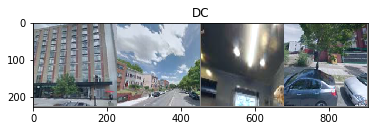

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs = torch.stack( inputs )
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:,1,:,:,:])

imshow(out, title=class_names[classes[1]])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    hist = {"train":[], "val":[]}
        
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            hist[phase] += [[epoch_loss, epoch_acc]]
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, hist

In [8]:
def visualize_model(model, num_images=6, dl = dataloaders['val'], topk= False ):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if topk:
                _, preds = torch.topk(outputs, 4)
            else:
                _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                if topk:
                    ax.set_title('predicted: {}\n actual: {}'.format(
                        " ".join(map(lambda x: class_names[x], list(preds[j]))),
                        class_names[labels[j]]))
                else:
                    ax.set_title('predicted: {}\n actual: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
class SequenceModel(nn.Module):
    
    def __init__(self, embedding_d, hidden_d, out_dim, transformer, num_layers=2):
        super(SequenceModel, self).__init__()
        self.embedding_d = embedding_d
        self.hidden_d = hidden_d
        self.num_layers = num_layers
        
        self.embed = transformer
        self.lstm = nn.LSTM(
            embedding_d, hidden_d, num_layers=num_layers ).to(device)
        self.hidden = self.init_hidden()
        self.hidden2tag = nn.Linear(hidden_d, out_dim)
        
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, BATCH, self.hidden_d)
                torch.zeros(self.num_layers, BATCH, self.hidden_d))
    
    def forward(self, inp):
        batch_s = inp.size(1)
        embeds = torch.stack([transf(x[i]) for i in range(len(x))]).squeeze()
        print(embeds.shape, len(inp))
        lstm_out, self.hidden = self.lstm(
            embeds, self.hidden)
        ret = self.hidden2tag(lstm_out)
        return ret

In [1]:
# Do Not rerun this

model_ft = torch.load("./models/resnet_trained")

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
# model_ft.classifier = nn.Sequential(# last layer to retrain
#      nn.Dropout(p=0.5),
#      nn.Conv2d(512, len(class_names), kernel_size=(1,1),stride=(1,1)),
#      nn.ReLU(inplace=True),
#      nn.AvgPool2d(kernel_size=13, stride=1, padding=0)
# )
# model_ft.num_classes = len(class_names)
hidden = 32

sequence_model = SequenceModel(num_ftrs,hidden,
                               len(class_names),
                               nn.Sequential(*list(model_ft.children())[:-1]).to(device)
                               )

# list(last_removed.children())[-1].parameters()

sequence_model = sequence_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam( sequence_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



NameError: name 'torch' is not defined

In [13]:
x,y = next(iter(dataloaders["test"]))

# res = sequence_model(x)
print(len(x))
x  = torch.stack(x).to(device)
# res = sequence_model(x[0])
# T = torch.stack([transf(x[i]) for i in range(len(x))]).squeeze()
# T.shape
# res


4


RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorCopy.c:20

In [12]:
# T = model_ft(x[0])

T = torch.stack([model_ft(x[i]) for i in range(len(x))]).squeeze()
sequence_model.lstm(T,sequence_model.hidden)


RuntimeError: CUDNN_STATUS_EXECUTION_FAILED

In [ ]:
model_ft, hist_new = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

In [ ]:
net2 = nn.Sequential(*list(model_ft.children())[:-1])
net2 = net2.to(device)
# pic = pic.to(device)
# res = sequence_model(pic.)

In [ ]:
fig = plt.figure()
model_ft.eval()
j = 1
for phase in ["train","test", "val"]:
    preds = []
    Y = []
    for x,y in dataloaders[phase]:
        _, prs = model_ft(x.to(device)).max(1)
        preds +=list(prs)
        Y += list(y)

    scor = metrics.accuracy_score(Y, preds)
    print(scor)
    ax = plt.subplot(1,3,j)
    ax.axis('off')
    j+=1
    CM = metrics.confusion_matrix(Y,preds)
    ax.matshow(CM.astype(np.double))
    plt.title(phase)

In [ ]:
preds = []
Y = []
for x,y in nt_dataloader:
    _, prs = model_ft(x.to(device)).max(1)
    preds +=list(prs)
    Y += list(y)

In [ ]:
x,y = next(iter(dataloaders["test"]))

In [ ]:
scor = metrics.accuracy_score(Y, preds)
print( scor )
print(metrics.f1_score(Y,preds, average="weighted"))
plt.matshow(metrics.confusion_matrix(Y,preds).astype(np.double))

In [ ]:
net = model_ft.
figure  = plt.figure(64, (8, 8), facecolor='black')

for panel  in range(0, net.weight.size(0)):
    ax = plt.subplot(8,8, panel+1)
    plt.axis('off')
    data = net.weight[panel]
    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
    plt.imshow(  data.transpose(0,1).cpu().transpose(1,2).data.cpu().numpy())
 

In [ ]:
# ?optim.Adagrad
res = model_ft(next(iter(dataloaders["train"]))[0].to(device))
res.topk(5)

In [ ]:
torch.save(model_ft, "./models/resnet_trained")

In [ ]:
model_ft = torch.load("models/resnet_trained")

In [ ]:
# plt.subplot(num_images//4, 4, images_so_far)
visualize_model(model_ft, 6, nt_dataloader, topk=True)

In [ ]:
graph = make_dot(res.mean(),params= dict(model_ft.named_parameters()))
graph.render("out.gz", view=True)

In [ ]:
iter(model_ft.modules)

In [ ]:
rep = metrics.classification_report(np.asarray(Y), np.asarray(preds), target_names=class_names)
print (rep)


In [ ]:
import io, re

train = []
val   = []

with io.StringIO(FF) as f:
    for i in range(25):        
        l1 = f.readline()
        f.readline()
        l2 = f.readline()
        l3 = f.readline()
        res = re.search("(\d+)\/",l1)
        res2 = re.findall(": (\d+\.\d+)",l2)
        res3 = re.findall(": (\d+\.\d+)",l3)
        f.readline()
        train += [res2]
        val   += [res3]
    print("done")


In [ ]:
%matplotlib qt5
hist= hist_new
train = np.asarray(hist["train"])
val = np.asarray(hist["val"])

In [ ]:
plt.plot(range(30),train[:,0], label = "Train")
plt.plot(range(30),val[:,0], label = "Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.yticks(np.arange(1.3,2.3, step=0.2))